In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [4]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [5]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "successor", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step in the environment
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(len(action_probs), p=action_probs)
            successor, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, successor=successor, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done or t == 10000:
                break
                
            state = successor
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # Get return from here
            total_return = sum(discount_factor**i*trans.reward for i,trans in enumerate(episode[t:]))
            # Update baseline value
            estimator_value.update(transition.state, total_return)
            # Get baseline value and compute policy gradient target
            baseline_value = estimator_value.predict(transition.state)
            target = total_return - baseline_value
            # Update policy
            estimator_policy.update(transition.state, target, transition.action)
    return stats

In [6]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 2000, discount_factor=1.0)

Step 2 @ Episode 2000/2000 (-100.0))

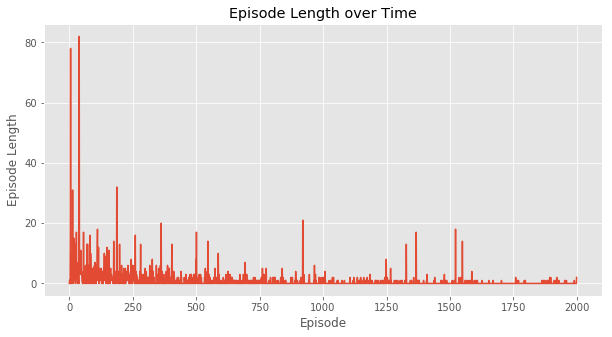

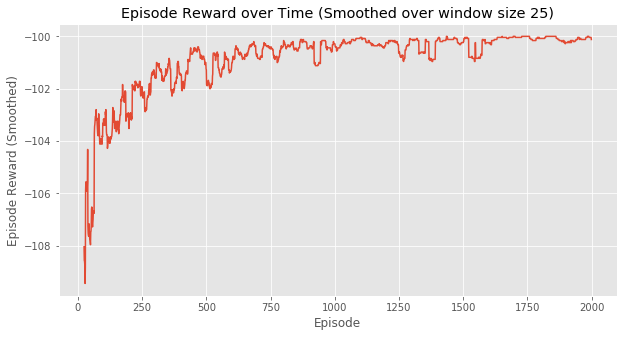

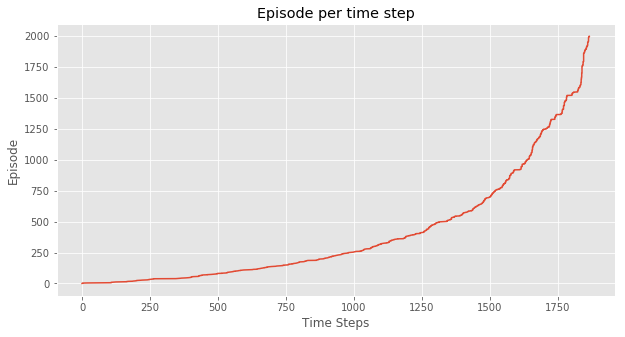

(<matplotlib.figure.Figure at 0x7f3816cae7b8>,
 <matplotlib.figure.Figure at 0x7f3812515f98>)

In [7]:
plotting.plot_episode_stats(stats, smoothing_window=25)